# IMBH population

We want to estimate the detection rates for a population of Intermediate Mass Black Holes.

We will need to generate such a population - let us neglect all astrophysics here, 
and just generate a random sample of masses for demonstration purposes.

In [47]:
!pip install -q git+https://github.com/janosch314/GWFish.git
!pip install -q numpy
!pip install -q astropy
!pip install -q matplotlib


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [48]:
import pandas as pd
import numpy as np
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt

In [49]:
rng = np.random.default_rng(seed=1)

ns = 10

total_masses = rng.normal(loc=1e4, scale=1e3, size=(ns,))
mass_ratios = rng.uniform(1, 10, size=(ns,))
redshifts = rng.uniform(0.5, 10, size=(ns,))

parameters = pd.DataFrame.from_dict({
   'mass_1': total_masses / (1+mass_ratios), 
   'mass_2': total_masses * mass_ratios / (1+mass_ratios), 
   'redshift': redshifts,
   'luminosity_distance': cosmo.luminosity_distance(redshifts),
   'theta_jn': np.arccos(rng.uniform(-1., 1., size=(ns,))),
   'dec': np.arccos(rng.uniform(-1., 1., size=(ns,))) - np.pi / 2.,
   'ra': rng.uniform(0, 2. * np.pi, size=(ns,)),
   'psi': rng.uniform(0, 2. * np.pi, size=(ns,)),
   'phase': rng.uniform(0, 2. * np.pi, size=(ns,)),
   'geocent_time': rng.uniform(1735257618, 1766793618, size=(ns,)) # full year 2035
})


Text(0, 0.5, 'Secondary mass [$M_\\odot$]')

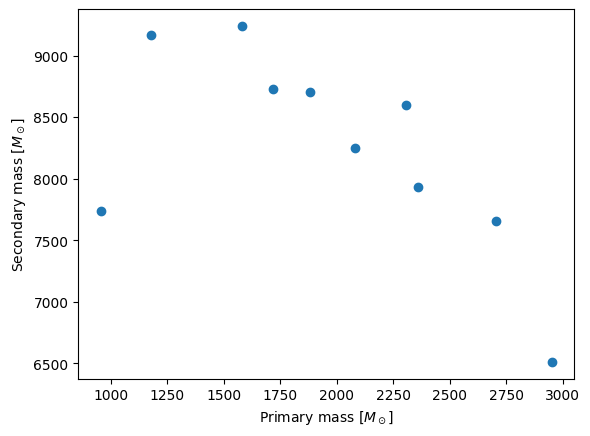

In [50]:
plt.scatter(parameters['mass_1'], parameters['mass_2'])
plt.xlabel('Primary mass [$M_\odot$]')
plt.ylabel('Secondary mass [$M_\odot$]')

In [51]:
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors
from GWFish.modules.waveforms import IMRPhenomD, TaylorF2

network = Network(['LGWA'], detection_SNR=(0, 0))

detected, snr, errors, _ = compute_network_errors(
   network, 
   parameters, 
   waveform_model='IMRPhenomD',
   waveform_class=IMRPhenomD,
   fisher_parameters=['geocent_time'],
)

snr = snr[detected]
errors = errors[detected, :]


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.09it/s]


In [52]:
snr

array([ 2.33330712, 22.04894685, 10.07827027,  3.61893264,  3.65695329,
       10.04326199, 19.11935044, 14.57034034, 23.21663703,  8.28949032])

# Horizons

The horizon is defined as the maximum possible distance at which an optimally oriented source
can be detected.

In [53]:
from GWFish.modules import horizon, detection, waveforms

base_params = {
   'mass_1': 1e4, 
   'mass_2': 1e4, 
    "theta_jn": 0.,
    "psi": 0.,
    "phase": 0.,
    "geocent_time": 1800000000,
}

detector = detection.Detector('LGWA')

params = horizon.find_optimal_location(
    base_params=base_params,
    detector=detector,
    waveform_model='IMRPhenomD', 
    waveform_class=IMRPhenomD,
)

print(horizon.horizon(
    params=params, 
    detector= detector, 
    target_SNR= 9.0, 
    waveform_model='IMRPhenomD', 
    waveform_class=IMRPhenomD, 
    cosmology_model = cosmo, 
    source_frame_masses= True, 
    redefine_tf_vectors = False
))

(256899.68122018696, 22.106712683540778)


# Neutron star - White Dwarf binaries

In [54]:
dwd_params = {
   'mass_1': 1.4, 
   'mass_2': 1, 
    "theta_jn": 0.,
    "psi": 0.,
    "phase": 0.,
    "geocent_time": 1800000000,
    "max_frequency_cutoff": 1e-1,
}

detector.frequencyvector = np.linspace(0.05, 0.101, num=1000)

params = horizon.find_optimal_location(
    base_params=dwd_params,
    detector=detector,
    waveform_model='TaylorF2', 
    waveform_class=TaylorF2, 
)

print(horizon.horizon(
    params=params, 
    detector= detector, 
    target_SNR= 9.0, 
    waveform_model='TaylorF2', 
    waveform_class=TaylorF2, 
    cosmology_model = cosmo, 
    source_frame_masses= True, 
))

(22.19414406173448, 0.0049899310664263926)


In [55]:
from GWFish.modules import utilities, waveforms

parameters_with_distance = params | {'luminosity_distance': 22}

data_params = {
        'frequencyvector': detector.frequencyvector,
        'f_ref': 50.
    }
waveform_obj = waveforms.TaylorF2('TaylorF2', parameters_with_distance, data_params)
wave = waveform_obj()
t_of_f = waveform_obj.t_of_f

signal = detection.projection(parameters_with_distance, detector, wave, t_of_f)

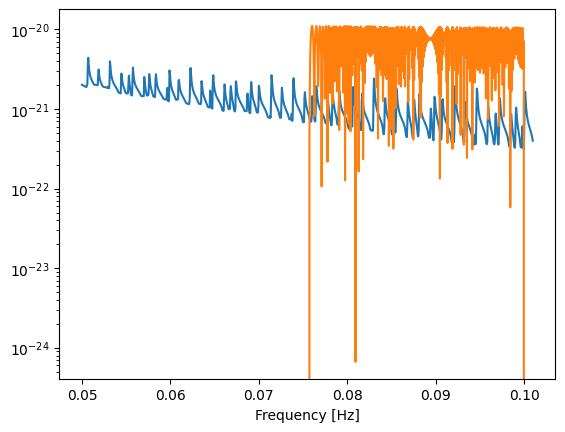

In [56]:
import matplotlib.pyplot as plt

f = detector.frequencyvector

psd = detector.components[0].Sn(f)

h_noise = np.sqrt(f * psd)
h_signal = 2 * f * np.abs(signal[:, 0])

plt.semilogy(f, h_noise)
plt.semilogy(f, h_signal)
plt.xlabel('Frequency [Hz]')
plt.show()